In [22]:
import numpy as np
import torch 
import matplotlib.pyplot as plt
import enum

import os
from PIL import Image
import cv2 #pip install opencv-python
import torchvision.transforms as transforms
import matplotlib.image as mpimg
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50
from torchvision import datasets, models, transforms
import torchvision
import copy
import sklearn.metrics
import time
import torch.utils
import torch.utils.data
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [23]:
%run preprocess.ipynb
%run stinna.ipynb
%run extraFunctions.ipynb

## Datasets

Split data into train set, validation set and test set with ratio 80/10/10

In [24]:
# import splitfolders
# splitfolders.ratio(PATHbirdsWithBackground, output="output",seed=42, ratio=(0.8,0.1,0.1) )

In [25]:
PATH_TEST = "split_withbackground/test"
PATH_TRAIN = "split_withbackground/train"
PATH_VAL = "split_withbackground/val"
PATH_FEEDER = "feeder-data"

ResNet accepts input images of shape `(3 x 224 x 224)` and they must be loaded in to a range of `[0,1]` and normalised using `mean = [0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]` (https://pytorch.org/hub/pytorch_vision_resnet/). Our data already has the correct size, so here, we simply add `ToTensor()`, which converts the images from `(H x W x C)` in range `[0,255]` to `(C x H x W)` in range `[0.0,1.0]`, and the normalisation. 

In [26]:
preprocess_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Datasets from our imagefolders

In [27]:
dataset_test = datasets.ImageFolder(PATH_TEST, preprocess_transforms)
dataset_train = datasets.ImageFolder(PATH_TRAIN, preprocess_transforms)
dataset_val = datasets.ImageFolder(PATH_VAL, preprocess_transforms)
dataset_feeder = datasets.ImageFolder(PATH_FEEDER, preprocess_transforms)

dataset_size_train = len(dataset_train)
dataset_size_val = len(dataset_val)

print('No of images in training set: {}'.format(len(dataset_train)))
print('No of images in validation set: {}'.format(len(dataset_val)))
print('No of images in test set: {}'.format(len(dataset_test)))
print('No of images in feeder set: {}'.format(len(dataset_feeder)))

class_labels = dataset_val.classes
print('Labels: {}'.format(class_labels))
print('Labels (feeder): {}'.format(dataset_feeder.classes))

No of images in training set: 835
No of images in validation set: 104
No of images in test set: 105
No of images in feeder set: 15079
Labels: ['blueTit', 'chaffinch', 'coalTit', 'goldfinch', 'greatTit', 'robin', 'starling']
Labels (feeder): ['blueTit', 'chaffinchF', 'chaffinchM', 'coalTit', 'goldfinch', 'greatTit', 'robin', 'starling']


DataLOADERS (which is what we feed to the training)

In [28]:
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=4, shuffle=True, num_workers=4)
dataloader_validation = torch.utils.data.DataLoader(dataset_val, batch_size=4, shuffle=True, num_workers=4)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=4, shuffle=False, num_workers=4)
dataloader_feeder = torch.utils.data.DataLoader(dataset_feeder, batch_size=4, shuffle=False, num_workers=4)


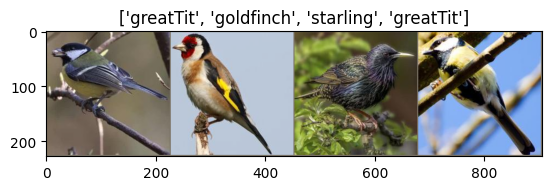

In [29]:
# for taking a little look at the data :) 
inputs, classes = next(iter(dataloader_train))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_labels[x] for x in classes])

In [30]:
# Extracting a subset to be able to test our code before doing big boi training
subset1 = torch.utils.data.Subset(dataset_train, np.random.choice(len(dataset_train), 16, replace=False))
subset2 = torch.utils.data.Subset(dataset_val, [1,8,9,16, 60, 80, 98, 100, 103, 20,31, 40,50,70,90,88])
print(subset1.dataset)
print(subset1.indices)
print(subset2.dataset)
print(subset2.indices)
dataloader_tiny = DataLoader(subset1, batch_size=4, shuffle=True, num_workers=0)
dataloader_tiny_val = DataLoader(subset2, batch_size=4, shuffle=True, num_workers=0)

Dataset ImageFolder
    Number of datapoints: 835
    Root location: split_withbackground/train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
[780  52 661 737 755 392 629  69 120 524 517 242 823 588 366 695]
Dataset ImageFolder
    Number of datapoints: 104
    Root location: split_withbackground/val
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
[1, 8, 9, 16, 60, 80, 98, 100, 103, 20, 31, 40, 50, 70, 90, 88]


## Importing ResNet50 model

In [31]:
pretrained_weights = models.ResNet50_Weights.DEFAULT
def load_resnet50(weights = pretrained_weights):
    model = resnet50(weights=weights)
    print(model)
    #Replace last layer to match our 7 classes
    model.fc = torch.nn.Linear(model.fc.in_features, 7)
    print(model.fc)
    return model

In [32]:
resnet50 = load_resnet50()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Put the pedal to the metal and use GPU

In [33]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Freezing and unfreezing for transfer learning

In [34]:
# Freeze all layers (i.e., disable training so we dont start from scratch)
for param in resnet50.parameters():
    param.requires_grad = False

# Unfreeze final layer (named fc) s.t. we only train that to get a better starting point for fine tuning
for param in resnet50.fc.parameters():
    param.requires_grad = True

# Put the model on the GPU
resnet50 = resnet50.to(device)

#Use stochastic gradient descent and optimize parameters
optimizer = torch.optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9)

## Train function

In [35]:
def train_model(model, optimizer, num_epoch=5, train = dataloader_train, validation= dataloader_validation):
    acc_train = []
    loss_train = []
    acc_validation = []
    loss_validation = []
    best_acc = 0.0
    best_model_weight = copy.deepcopy(model.state_dict())

    since = time.time()
    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch+1, num_epoch))
        print("-"*10)
        #training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in train:
            inputs = inputs.to(device)
            labels = labels.to(device)

            #zero the parameter gradients 
            optimizer.zero_grad()

            #forward
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                criterion = torch.nn.CrossEntropyLoss()
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss_train = running_loss / dataset_size_train
        epoch_acc_train = running_corrects.double() / dataset_size_train
        acc_train.append(epoch_acc_train.item())
        loss_train.append(epoch_loss_train)
        print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss_train, epoch_acc_train))

        #validation phase
        model.eval()
        running_loss_val = 0.0
        running_corrects_val = 0
        for inputs, labels in validation:
            inputs = inputs.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                criterion = torch.nn.CrossEntropyLoss()
                loss = criterion(outputs, labels)
            running_loss_val += loss.item() * inputs.size(0)
            running_corrects_val += torch.sum(preds == labels.data)
        epoch_loss_val = running_loss_val / dataset_size_val
        epoch_acc_val = running_corrects_val.double() / dataset_size_val
        acc_validation.append(epoch_acc_val.item())
        loss_validation.append(epoch_loss_val)
        print('Val Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss_val, epoch_acc_val))
        
        if(epoch_acc_val > best_acc):
            best_acc = epoch_acc_val
            best_model_weight = copy.deepcopy(model.state_dict())
        
        time_epoch_val = time.time() - since           
        print('Epoch time {:.0f}m {:.0f}s'.format(time_epoch_val // 60, time_epoch_val % 60))
        print("-"*10)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Validation accuracies:")
    print(acc_validation)
    data = {"train_loss": loss_train, "val_loss": loss_validation, "train_acc": acc_train, "val_acc": acc_validation}
    model.load_state_dict(best_model_weight)
    return model, data
